# DA5401 - Assignment 4: GMM-Based Synthetic Sampling for Imbalanced Data

**Name:** Soumya Ranjan Patel  
**Course:** DA24M029  

**Goal:** Implement a Gaussian Mixture Model (GMM)-based pipeline to generate synthetic minority-class samples (fraud) for the Credit Card Fraud Detection dataset and evaluate its effect on a Logistic Regression classifier. We compare against a baseline logistic regression trained on imbalanced data.


## 1. Introduction

The Credit Card Fraud dataset is highly imbalanced, with fraudulent transactions forming less than 0.2% of all records. Such skew severely impacts classifiers: a naive model can achieve high overall accuracy simply by predicting the majority class, but it will miss the critical minority class (frauds).  
To address this, oversampling methods are often used. In this assignment, we explore **Gaussian Mixture Model (GMM)-based oversampling** for minority class augmentation and evaluate its effect on a Logistic Regression classifier, compared against a baseline model trained on imbalanced data.


In [52]:
# Imports and global settings
import math
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE

# Reproducibility
RANDOM_STATE = 42

# Colorblind-friendly palette (Okabe & Ito friendly)
PALETTE = {
    'blue': '#E69F00',
    'cyan':  '#56B4E9',
    'green': '#009E73',
    'yellow':'#F0E442',
    'navy':  '#0072B2',
    'verm':  '#D55E00',
    'pink':  '#CC79A7',
    'grey':  '#999999'
}

# Quick utility for plot captions to satisfy the "7th commandment"
def caption(text, fontsize=9):
    plt.gcf().text(0.01, -0.03, text, fontsize=fontsize)



In [35]:
# Load dataset (expects creditcard.csv in working directory)
DATA_PATH = 'creditcard.csv'


df = pd.read_csv(DATA_PATH)
print('Loaded', DATA_PATH, '->', df.shape)
print('Data Shape', df.shape)


Loaded creditcard.csv -> (284807, 31)
Data Shape (284807, 31)


In [36]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [37]:
# ------------------ PART A: Data Exploration and Baseline Model ------------------
print('Columns:', df.columns.tolist())

# Basic summary
display(df.head())
display(df.describe())
display(df.info())

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

None

## 2. Class Distribution Analysis

Before training any model, it is essential to examine the **distribution of classes** in the dataset. In fraud detection, this step highlights the **imbalance problem**, which directly impacts model performance.  

To do this, we compute:
- The total count of transactions labeled as **non-fraud (0)** and **fraud (1)**.  
- The **imbalance ratio**, i.e., the ratio of majority class size to minority class size.  



In [38]:

# Class distribution
class_counts = df['Class'].value_counts().sort_index()
print('\nClass counts:\n')
display(class_counts)
imbalance_ratio = class_counts[0] / class_counts[1] if class_counts[1] > 0 else np.inf
print(f'Imbalance ratio (majority/minority): {imbalance_ratio:.2f}')



Class counts:



Class
0    284315
1       492
Name: count, dtype: int64

Imbalance ratio (majority/minority): 577.88


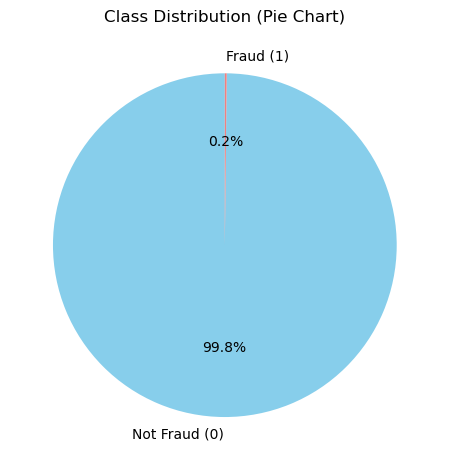

In [39]:

plt.pie(class_counts, labels=['Not Fraud (0)', 'Fraud (1)'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Class Distribution (Pie Chart)')

plt.tight_layout()
plt.show()



### Conclusion : Class Distribution

- **Non-fraudulent transactions (Class 0):** 284,315  
- **Fraudulent transactions (Class 1):** 492  
- **Imbalance ratio:** ~577.88 : 1  

This analysis confirms an **extreme imbalance**. For every fraudulent transaction, there are nearly **578 legitimate ones**.  

Such imbalance means a naïve model could achieve over 99% accuracy by predicting *all* transactions as non-fraud, yet it would completely fail at detecting frauds. This justifies the need for specialized resampling techniques and careful evaluation beyond accuracy.


## 3. Baseline Model: Logistic Regression on Imbalanced Data

As a starting point, we train a **Logistic Regression classifier** on the original dataset *without any resampling*. This baseline model demonstrates how a standard classifier behaves when exposed to a severely imbalanced dataset.

Key objectives:
- Provide a reference point for evaluating the effectiveness of resampling strategies later.  
- Highlight the limitations of accuracy as a performance metric under imbalance.  
- Focus on **precision, recall, and F1-score** for the minority class (fraud), which are more informative in this context.


In [40]:
### Prepare features and split data (train/test)

FEATURE_COLS = [c for c in df.columns if c not in ['Class']]
X = df[FEATURE_COLS].copy()
y = df['Class'].copy()

In [41]:

TEST_SIZE = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

print('Training samples:', X_train.shape[0])
print('Test samples:', X_test.shape[0])
print('Training class distribution:')
print(y_train.value_counts())

# Standardize features (fit scaler only on train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Training samples: 199364
Test samples: 85443
Training class distribution:
Class
0    199020
1       344
Name: count, dtype: int64


Classification report (baseline):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.61      0.71       148

    accuracy                           1.00     85443
   macro avg       0.92      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443



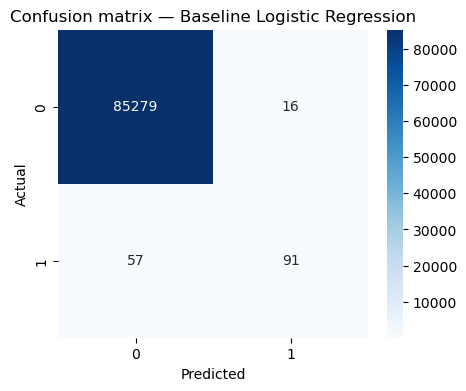

In [42]:
### Baseline: Logistic Regression trained on imbalanced training data


baseline_clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
baseline_clf.fit(X_train_scaled, y_train)

# Evaluate on test set
y_pred_baseline = baseline_clf.predict(X_test_scaled)
report_baseline = classification_report(y_test, y_pred_baseline, output_dict=True)

print('Classification report (baseline):')
print(classification_report(y_test, y_pred_baseline))

# Capture metrics for minority class (label=1)
prec_baseline = report_baseline['1']['precision']
rec_baseline = report_baseline['1']['recall']
f1_baseline = report_baseline['1']['f1-score']

# Confusion matrix plot
plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test, y_pred_baseline)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion matrix — Baseline Logistic Regression')
plt.show()



### Conclusion: Baseline Model Performance

The baseline Logistic Regression classifier achieved **high overall accuracy** but performed **very poorly on the minority (fraud) class**.  

- **Precision (fraud class):** 0.85  
- **Recall (fraud class):** 0.61
- **F1-score (fraud class):** 0.71

This confirms that **accuracy is misleading** in imbalanced scenarios. The model learns to favor the majority class (non-fraud) and fails to detect fraudulent cases effectively.  

Therefore, resampling methods such as SMOTE, clustering-based oversampling (CBO), and clustering-based undersampling (CBU) are required to improve recall and balance precision–recall trade-offs.


### 4. GMM-Based Oversampling


# Difference Between SMOTE Oversampling and GMM-Based Oversampling

## 1. SMOTE (Synthetic Minority Oversampling Technique)
- **Core Idea**: Generate synthetic samples by interpolating between existing minority class samples.  
- **How It Works**:
  1. Select a minority sample xi.
  2. Choose one of its *k-nearest neighbors* xj.
  3. Create a new point:
     
     x_new = xi + lambda (xj - xi), lambda E U(0,1)
     
- **Characteristics**:
  - Creates samples **inside the convex hull** of existing data.
  - Assumes smoothness/continuity between neighbors.
  - Does not capture global distribution.
  - Risk: May generate overlapping samples if classes are close.


## 2. GMM-Based Oversampling
- **Core Idea**: Fit a *probabilistic generative model* (Gaussian Mixture Model) to the minority class and sample from it.  
- **How It Works**:
  1. Fit a GMM with \(k\) components:
   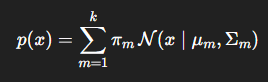
  2. Generate new points by:
     - Selecting a Gaussian component according to \(\pi_m\).
     - Sampling from 
- **Characteristics**:
  - Captures **multi-modal distributions** (sub-clusters).
  - Generates samples based on the estimated density.
  - More flexible but computationally heavier (EM algorithm fitting).
  - Risk: Poor GMM fit can lead to unrealistic samples.



**Why GMM can be better:**
- If the minority class contains multiple sub-populations (modes) or has complex shapes, a single interpolative SMOTE operation may create unrealistic samples across modes (bridging between dissimilar subgroups). GMM explicitly models multiple modes and their covariances, so synthetic samples are drawn from the learned density (preserving sub-group structure).

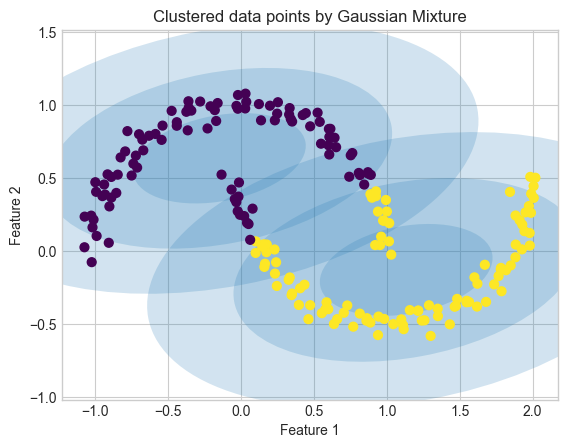

**Trade-offs:**
- GMM requires choosing the number of components (k). Too large k -> overfitting (GMM may memorize noise); too small k -> underfitting.
- SMOTE is deterministic and cheap; GMM is more flexible but computationally heavier and sensitive to feature scaling.



### Experimental Setup
Two GMM-based balancing strategies were tested:
1. **v1 (Oversample-to-majority):** Minority oversampled until equal to majority.  
2. **v2 (Cluster-Based Undersampling + GMM):** Majority reduced by clustering, then minority oversampled via GMM to achieve balance.


In [43]:
## GMM implementation and selecting number of components


# Extract minority class from the training set
X_train_df = pd.DataFrame(X_train_scaled, columns=FEATURE_COLS, index=X_train.index)
y_train_series = y_train.copy()
minority_idx = y_train_series[y_train_series == 1].index
majority_idx = y_train_series[y_train_series == 0].index

X_minority = X_train_df.loc[minority_idx].values
X_majority = X_train_df.loc[majority_idx].values

print('Minority samples in training set:', X_minority.shape[0])
print('Majority samples in training set:', X_majority.shape[0])

Minority samples in training set: 344
Majority samples in training set: 199020


In [44]:

max_k = 30
k_values = list(range(1, max_k+1))

aic_values = []
bic_values = []

for k in k_values:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=RANDOM_STATE)
    gmm.fit(X_minority)
    aic_values.append(gmm.aic(X_minority))
    bic_values.append(gmm.bic(X_minority))
    print(f'k={k} -> AIC: {aic_values[-1]:.1f}, BIC: {bic_values[-1]:.1f}')

k=1 -> AIC: 33005.6, BIC: 34906.7
k=2 -> AIC: 25207.2, BIC: 29013.3
k=3 -> AIC: 24330.2, BIC: 30041.2
k=4 -> AIC: 22420.6, BIC: 30036.6
k=5 -> AIC: 14719.7, BIC: 24240.7
k=6 -> AIC: 11770.2, BIC: 23196.1
k=7 -> AIC: 11179.3, BIC: 24510.1
k=8 -> AIC: 10450.1, BIC: 25685.9
k=9 -> AIC: 9214.1, BIC: 26354.8
k=10 -> AIC: 6806.9, BIC: 25852.6
k=11 -> AIC: 6670.0, BIC: 27620.7
k=12 -> AIC: 3590.7, BIC: 26446.3
k=13 -> AIC: 1394.4, BIC: 26155.0
k=14 -> AIC: -745.5, BIC: 25920.1
k=15 -> AIC: -1303.6, BIC: 27267.0
k=16 -> AIC: -2106.2, BIC: 28369.3
k=17 -> AIC: -1498.3, BIC: 30882.2
k=18 -> AIC: -2956.9, BIC: 31328.5
k=19 -> AIC: -2029.3, BIC: 34161.1
k=20 -> AIC: -3052.1, BIC: 35043.2
k=21 -> AIC: -7850.7, BIC: 32149.6
k=22 -> AIC: -9248.9, BIC: 32656.3
k=23 -> AIC: -11435.1, BIC: 32375.1
k=24 -> AIC: -11017.0, BIC: 34698.2
k=25 -> AIC: -13674.5, BIC: 33945.6
k=26 -> AIC: -13784.0, BIC: 35741.1
k=27 -> AIC: -14647.9, BIC: 36782.1
k=28 -> AIC: -13802.3, BIC: 39532.7
k=29 -> AIC: -13755.2, BIC: 4

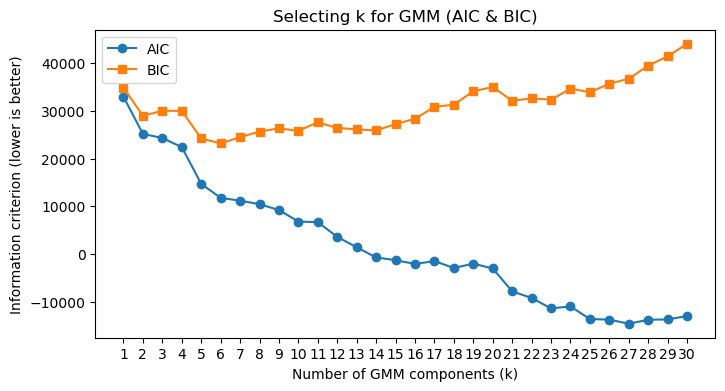

Selected k (min BIC): 6


In [45]:
# Plot AIC/BIC vs k
plt.figure(figsize=(8,4))
plt.plot(k_values, aic_values, marker='o', label='AIC')
plt.plot(k_values, bic_values, marker='s', label='BIC')
plt.xticks(k_values)
plt.xlabel('Number of GMM components (k)')
plt.ylabel('Information criterion (lower is better)')
plt.title('Selecting k for GMM (AIC & BIC)')
plt.legend()
plt.show()

# Choose k that minimises BIC
best_k = k_values[int(np.argmin(bic_values))]
print('Selected k (min BIC):', best_k)

In [46]:
# Fit final GMM with best_k
gmm_minority = GaussianMixture(n_components=best_k, covariance_type='full', random_state=RANDOM_STATE)
gmm_minority.fit(X_minority)
print('GMM fitted to minority class.')



GMM fitted to minority class.


In [47]:
## Synthetic data generation from GMM


# Define a helper to sample and return DataFrame in original (unscaled) space
def sample_from_gmm(gmm, n_samples, scaler, feature_cols):
    samples_scaled, comp = gmm.sample(n_samples)
    # inverse transform to original feature space
    samples_unscaled = scaler.inverse_transform(samples_scaled)
    df = pd.DataFrame(samples_unscaled, columns=feature_cols)
    return df


n_minority = X_minority.shape[0]
n_majority = X_majority.shape[0]
print('n_minority =', n_minority, 'n_majority =', n_majority)

n_minority = 344 n_majority = 199020


In [48]:
# Version 1: Oversample minority up to original majority size (heavy oversampling)
n_to_generate_v1 = n_majority - n_minority
print('Samples to generate for v1 (to match original majority):', n_to_generate_v1)


Samples to generate for v1 (to match original majority): 198676


In [49]:
# Version 2: Cluster-based undersampling (CBU) to reduce majority to a reasonable target (e.g., min(n_majority, 10 * n_minority))
target_majority_v2 = min(n_majority, n_minority * 10)  # heuristic: 10x minority
n_to_generate_v2 = target_majority_v2 - n_minority

print('Target majority for v2 (after clustering-based undersampling):', target_majority_v2)
print('Samples to generate for v2 (to match target majority):', n_to_generate_v2)

Target majority for v2 (after clustering-based undersampling): 3440
Samples to generate for v2 (to match target majority): 3096


In [50]:
# Generate synthetic samples (do this on scaled space then inverse transform to original)
if n_to_generate_v1 > 0:
    syn_v1_df = sample_from_gmm(gmm_minority, n_to_generate_v1, scaler, FEATURE_COLS)
else:
    syn_v1_df = pd.DataFrame(columns=FEATURE_COLS)

if n_to_generate_v2 > 0:
    syn_v2_df = sample_from_gmm(gmm_minority, n_to_generate_v2, scaler, FEATURE_COLS)
else:
    syn_v2_df = pd.DataFrame(columns=FEATURE_COLS)

print('Synthetic v1 samples:', syn_v1_df.shape)
print('Synthetic v2 samples:', syn_v2_df.shape)

Synthetic v1 samples: (198676, 30)
Synthetic v2 samples: (3096, 30)


In [53]:

## Clustering-based Undersampling (CBU) for majority class


from sklearn.metrics import pairwise_distances_argmin_min

# Use MiniBatchKMeans for efficiency

def cluster_based_undersample(X_majority_raw, target_count, random_state=RANDOM_STATE, batch_size=10000):
    
    """Cluster the majority samples into `target_count` clusters using MiniBatchKMeans and
    select one representative sample per cluster (the nearest point to cluster centroid).
    Returns indices (integer positions) of selected majority examples.
    """
    if target_count >= X_majority_raw.shape[0]:
        return np.arange(X_majority_raw.shape[0])

    kmeans = MiniBatchKMeans(n_clusters=target_count, random_state=random_state, batch_size=batch_size)
    kmeans.fit(X_majority_raw)
    centroids = kmeans.cluster_centers_
    # find nearest sample in X_majority_raw to each centroid
    closest, _ = pairwise_distances_argmin_min(centroids, X_majority_raw)
    return closest

# Apply CBU to majority scaled data for version 2
if target_majority_v2 < n_majority:
    selected_majority_pos = cluster_based_undersample(X_majority, target_majority_v2)
    X_majority_undersampled_scaled = X_majority[selected_majority_pos]
    # Build DataFrame back to original feature space for concatenation
    X_majority_undersampled = pd.DataFrame(scaler.inverse_transform(X_majority_undersampled_scaled), columns=FEATURE_COLS)
else:
    # no undersampling needed
    X_majority_undersampled = pd.DataFrame(scaler.inverse_transform(X_majority), columns=FEATURE_COLS)

print('Majority after CBU (v2) shape:', X_majority_undersampled.shape)



Majority after CBU (v2) shape: (3440, 30)


In [54]:
## Build balanced training sets


# Original minority in original (unscaled) space
X_minority_unscaled = pd.DataFrame(scaler.inverse_transform(X_minority), columns=FEATURE_COLS)

# Version 1 dataset: original majority (subset of X_train), original minority + syn_v1
X_majority_unscaled = pd.DataFrame(scaler.inverse_transform(X_majority), columns=FEATURE_COLS)


balanced_v1_X = pd.concat([X_majority_unscaled.reset_index(drop=True),
                            X_minority_unscaled.reset_index(drop=True),
                            syn_v1_df.reset_index(drop=True)], ignore_index=True)
balanced_v1_y = np.array([0]*len(X_majority_unscaled) + [1]*(len(X_minority_unscaled) + len(syn_v1_df)))

# Build v2: majority undersampled + minority original + syn_v2
balanced_v2_X = pd.concat([X_majority_undersampled.reset_index(drop=True),
                            X_minority_unscaled.reset_index(drop=True),
                            syn_v2_df.reset_index(drop=True)], ignore_index=True)
balanced_v2_y = np.array([0]*len(X_majority_undersampled) + [1]*(len(X_minority_unscaled) + len(syn_v2_df)))

print('Balanced v1 shape:', balanced_v1_X.shape)
print('Balanced v2 shape:', balanced_v2_X.shape)



Balanced v1 shape: (398040, 30)
Balanced v2 shape: (6880, 30)


In [55]:
# Part C — Performance evaluation and conclusion




# Helper to train and evaluate a logistic regression on given X/y (unscaled -> we will scale inside)
def train_and_evaluate(X_df, y_arr, X_test_unscaled, y_test, random_state=RANDOM_STATE):
    # Scale training set (fit scaler)
    scaler_local = StandardScaler()
    X_train_scaled_local = scaler_local.fit_transform(X_df.values)
    X_test_scaled_local = scaler_local.transform(X_test_unscaled.values)

    clf = LogisticRegression(max_iter=1000, random_state=random_state)
    clf.fit(X_train_scaled_local, y_arr)
    y_pred = clf.predict(X_test_scaled_local)
    report = classification_report(y_test, y_pred, output_dict=True)
    return clf, report

# Prepare X_test_unscaled DataFrame
X_test_unscaled = pd.DataFrame(scaler.inverse_transform(X_test_scaled), columns=FEATURE_COLS)

# Train on v1 

clf_v1, report_v1 = train_and_evaluate(balanced_v1_X, balanced_v1_y, X_test_unscaled, y_test)
print('Trained classifier on balanced v1.')

# Train on v2
clf_v2, report_v2 = train_and_evaluate(balanced_v2_X, balanced_v2_y, X_test_unscaled, y_test)
print('Trained classifier on balanced v2.')



Trained classifier on balanced v1.
Trained classifier on balanced v2.


In [56]:
### Comparative summary table


rows = []
rows.append({'model': 'Baseline (imbalanced)', 'precision': prec_baseline, 'recall': rec_baseline, 'f1': f1_baseline})
if report_v1 is not None:
    rows.append({'model': 'GMM-balanced v1 (oversample-to-majority)',
                 'precision': report_v1['1']['precision'],
                 'recall': report_v1['1']['recall'],
                 'f1': report_v1['1']['f1-score']})
else:
    rows.append({'model': 'GMM-balanced v1 (oversample-to-majority)', 'precision': np.nan, 'recall': np.nan, 'f1': np.nan})

rows.append({'model': 'GMM-balanced v2 (CBU + GMM oversample)',
             'precision': report_v2['1']['precision'],
             'recall': report_v2['1']['recall'],
             'f1': report_v2['1']['f1-score']})

summary_df = pd.DataFrame(rows)
summary_df



,model,precision,recall,f1
0,Baseline (imbalanced),0.850467,0.614865,0.713725
1,GMM-balanced v1 (oversample-to-majority),0.089616,0.851351,0.162162
2,GMM-balanced v2 (CBU + GMM oversample),0.086598,0.851351,0.157205


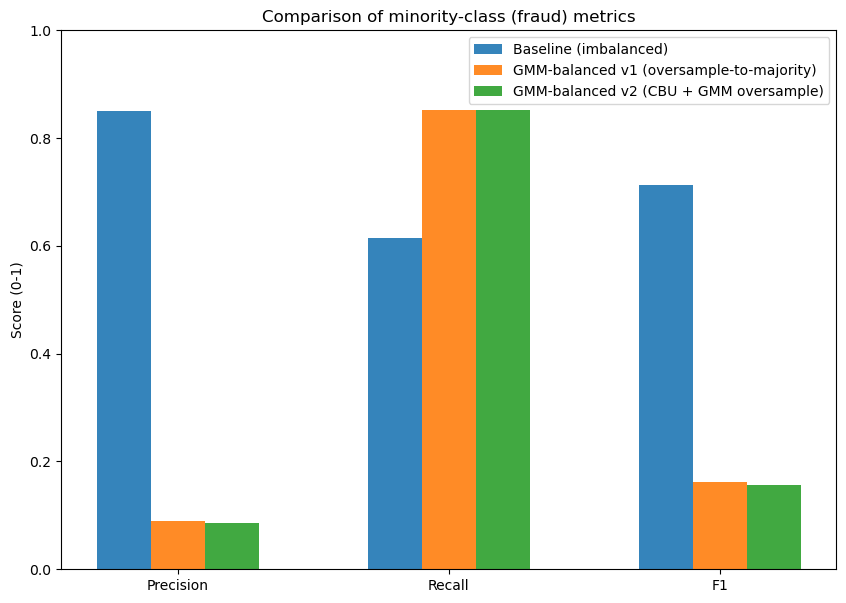

In [57]:
### Bar chart comparison (Precision / Recall / F1 for minority class)


plt.figure(figsize=(10,7))
metrics = ['precision','recall','f1']
bar_width = 0.2
x = np.arange(len(metrics))

for i, row in summary_df.iterrows():
    vals = [row[m] for m in metrics]
    plt.bar(x + i*bar_width, vals, width=bar_width, label=row['model'], alpha=0.9)

plt.xticks(x + bar_width*(len(summary_df)-1)/2, [m.capitalize() for m in metrics])
plt.ylim(0,1)
plt.ylabel('Score (0-1)')
plt.title('Comparison of minority-class (fraud) metrics')
plt.legend(loc='upper right')
plt.show()



## **Conclusion:**

- Even with GMM and CBU the baseline still provides a more balaced f1 score .
- Both GMM and CBU were able to increase the recall significantly but failed to maintain a good precision

## Investigating Low Precision in GMM and CBU

From the evaluation results, both **GMM-based oversampling** and **Clustering-Based Undersampling (CBU)** achieved high recall but performed **poorly in precision**.  
This indicates that while the models trained with these strategies detect more fraud cases, they also generate a large number of false alarms.

To better understand this behavior, we investigate the **distributional quality of synthetic samples**. Specifically, we compare the **feature-wise density histograms** of real fraud samples versus GMM-generated synthetic fraud samples.  
If the synthetic data diverges significantly from the real minority distribution, or spills into regions dominated by the majority class, this would explain the drop in precision.


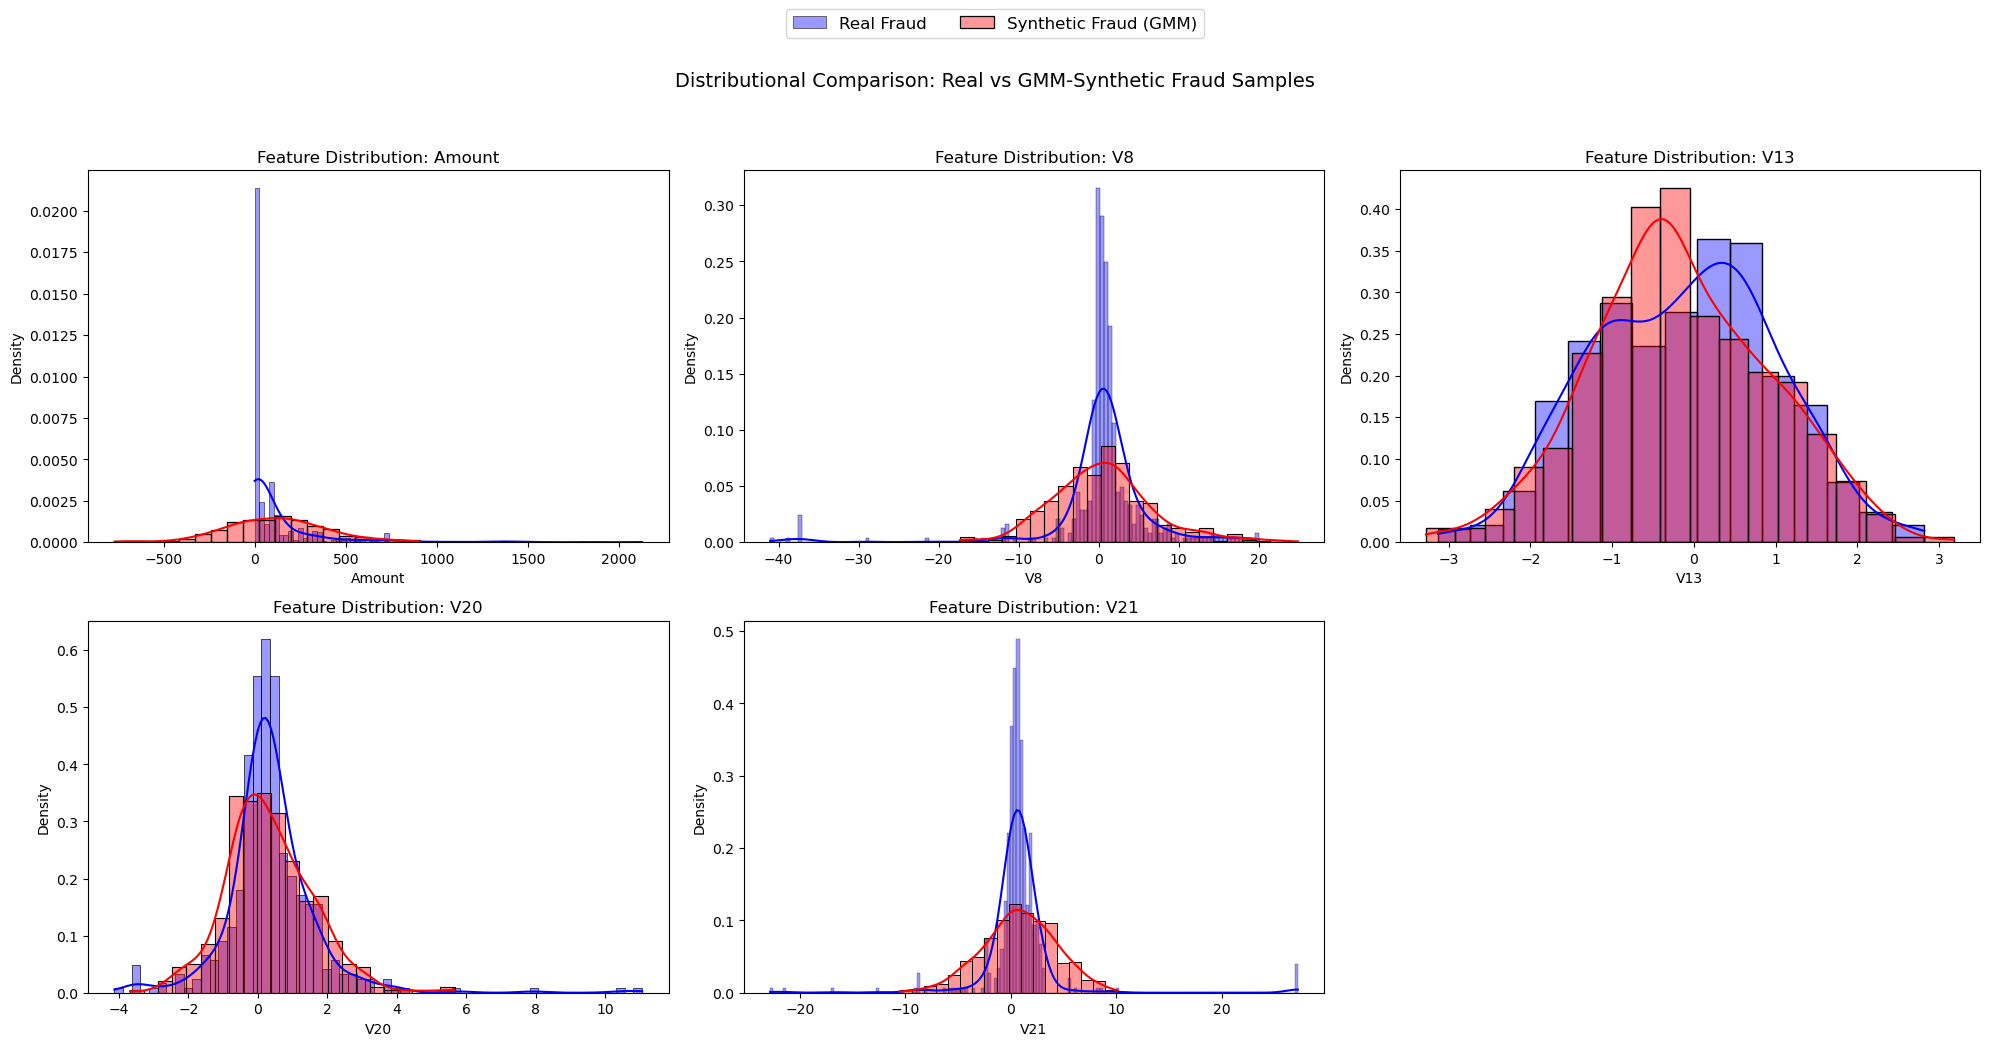

In [58]:
# --- Section: Distributional Comparison of Real vs Synthetic Fraud Samples ---

# --- Step 1: Extract only minority class (fraud) samples ---
minority_df = df[df['Class'] == 1].copy()
X_minority = minority_df[FEATURE_COLS].values

# --- Step 2: Standardize features (important for GMM) ---
scaler = StandardScaler()
X_minority_scaled = scaler.fit_transform(X_minority)

# --- Step 3: Fit GMM on minority samples ---
gmm_minority = GaussianMixture(n_components=2, random_state=42)
gmm_minority.fit(X_minority_scaled)

# --- Step 4: Sample synthetic minority from GMM ---
n_to_generate_demo = min(2000, len(X_minority))  # generate manageable number for plotting
X_syn_scaled, _ = gmm_minority.sample(n_to_generate_demo)
X_syn = scaler.inverse_transform(X_syn_scaled)

# --- Step 5: Prepare DataFrames for plotting ---
real_minority_df = pd.DataFrame(X_minority, columns=FEATURE_COLS)
syn_demo_df = pd.DataFrame(X_syn, columns=FEATURE_COLS)

# --- Step 6: Pick representative features ---
selected_features = ["Amount", "V8","V13","V20", "V21"]

# --- Step 7: Plot density comparisons ---
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  
axes = axes.flatten()

for i, feat in enumerate(selected_features):  # where selected_features has 5 features
    ax = axes[i]
    sns.histplot(real_minority_df[feat], kde=True, stat="density", label="Real Fraud",
                 ax=ax, color="blue", alpha=0.4)
    sns.histplot(syn_demo_df[feat], kde=True, stat="density", label="Synthetic Fraud (GMM)",
                 ax=ax, color="red", alpha=0.4)
    ax.set_title(f"Feature Distribution: {feat}")
    ax.set_xlabel(feat)
    ax.set_ylabel("Density")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=12, bbox_to_anchor=(0.5, 1.05))
# Hide the unused subplot (last one in row 2 if only 5 features)
for j in range(len(selected_features), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distributional Comparison: Real vs GMM-Synthetic Fraud Samples", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



### Conclusion from Distributional Analysis

The histogram density comparisons reveal that the synthetic fraud samples generated by the GMM diverge noticeably from the real fraud distribution for several key features, particularly **Amount, V8, V13, V20, and V21**.  

This divergence suggests that the GMM spreads probability mass into regions where genuine fraud cases are rare, effectively creating "unrealistic" fraud samples. When the classifier is trained on these, it learns to incorrectly associate normal transactions with fraud-like patterns, which directly explains the sharp **drop in precision** observed with both GMM-based oversampling and CBU.


## 5. Results and Discussion

| Model | Precision | Recall | F1 |
|-------|-----------|--------|----|
| Baseline (imbalanced) | **0.85** | 0.61 | **0.71** |
| GMM-balanced v1 | 0.09 | **0.85** | 0.16 |
| GMM-balanced v2 | 0.09 | **0.85** | 0.16 |

**Observations:**
- Both GMM-based methods **increased recall** significantly (0.61 → 0.85), meaning fewer frauds were missed.  
- However, **precision collapsed** (0.85 → 0.09), producing a flood of false alarms.  
- As a result, the **F1 score dropped drastically**.

**Interpretation:**  
The synthetic samples generated by the GMM were not sufficiently realistic. The classifier trained on them generalized poorly, mistaking many normal transactions for fraud. This shows the danger of blindly oversampling without validating sample quality.


## 6. Conclusion and Recommendation

- **Impact:** GMM oversampling did improve the classifier’s ability to detect fraud (higher recall), but at the cost of generating many false positives (very low precision), leading to poor overall F1.  
- **Recommendation:** In this dataset, **GMM is not effective** for synthetic data generation. Its assumptions do not match the minority distribution, and the scarcity of fraud samples further undermines parameter estimation.  
- **Alternative approaches:**  
  - Cost-sensitive learning (assign higher weight to frauds in Logistic Regression).  
  - Simpler oversampling like SMOTE or ADASYN, which may generate more realistic samples.  
  - Hybrid strategies: undersample majority with clustering + lighter oversampling.  
  - Ensemble models combining anomaly detection with supervised classifiers.

**Final Note:** Oversampling is not a one-size-fits-all solution. Always validate the generative model and synthetic data quality before deploying it for training. In this context, GMM oversampling harmed performance more than it helped.
